## 1. ENVIR PREPARATION

In [ ]:
#Additional pip installs
!pip install rasterio pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.6 MB/s eta 0:00:00


In [ ]:
#Libraries used in project
import os
import joblib
import datetime
import numpy as np
import pandas as pd

#Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
import rasterio as rio

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. GENERAL VARIABLES

In [ ]:
# directory where we will output figures
FIGURE_OUTPUT_DIR = 'output/figures'

# directory where we will output raster
RASTER_OUTPUT_DIR = 'output/raster'

# directory where we will output our models
MODEL_OUTPUT_DIR = 'models'

# image path
IMAGE_PATH_TRAIN = '/content/data/images/train'
MASK_PATH_TRAIN = '/content/data/masks/train'
IMAGE_PATH_VALIDATE = '/content/data/images/validate'
MASK_PATH_VALIDATE = '/content/data/masks/validate'
IMAGE_TO_PREDICT_PATH = '/content/data/to_predict'

# ratio of the dataset split for testing
TEST_RATIO = 0.15

# number of sets
SET_NUMBER = 2

# controls random seed for reproducibility
RANDOM_STATE = 101

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.float32

## 3. CODE





In [ ]:
#Creating directories

for set in range(SET_NUMBER):
  os.makedirs(IMAGE_PATH_TRAIN+f'/set{set+1}', exist_ok=True)
  os.makedirs(IMAGE_PATH_TRAIN+f'/set{set+1}', exist_ok=True)
  os.makedirs(MASK_PATH_TRAIN+f'/set{set+1}', exist_ok=True)

os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)
os.makedirs(IMAGE_TO_PREDICT_PATH, exist_ok=True)
os.makedirs(IMAGE_PATH_VALIDATE, exist_ok=True)
os.makedirs(MASK_PATH_VALIDATE, exist_ok=True)

In [ ]:
class RasterDataManipulator:
  def __init__(self, data_folder):
    self.data_folder = data_folder
    self.band_config = []
    self.file_list = []
    self.data_list = []
    self.date_list = []
    self.img_np_array = []
    self.date_np_array = []
    self.col_names = []

  #Setting band config
  def set_band_config(self, band_range):
    self.band_config = [i for i in range(1,band_range+1)]
    for band in self.band_config:
      col = f'band{band}'
      self.col_names.append(col)

  #Checking file lists
  def check_file_list(self):
    if len(self.file_list) == 0:
      self.prepare_file_list()
    else:
      pass

  #Getting file lists
  def prepare_file_list(self):
    for filename in os.scandir(self.data_folder):
      if filename.is_file():
        self.file_list.append(filename.path)
    self.file_list = sorted(self.file_list)

  #Getting data from image
  def prepare_original_data_as_list(self):
    for path in self.file_list:
      date = path[-15:-5]
      self.date_list.append(date)
      with rio.open(path) as src:
        data = src.read(self.band_config, out_dtype=DATA_TYPE)
        self.data_list.append(data)

  #2D array for dataframe
  def data_list_to_2d_array(self):
    date_arr = []
    img_arr = []
    B, W, H = self.data_list[0].shape
    new_shape = (W*H,B)
    for index, data in enumerate(self.data_list):
      date = self.date_list[index]
      img = np.empty(new_shape, dtype=DATA_TYPE)
      for band in self.band_config:
        img[:,band-1] = data[band-1].reshape(W*H)
      date_arr.append([date] * (W*H))
      img_arr.append(img)
    self.img_np_array = np.vstack(img_arr)
    self.date_np_array =  np.array(date_arr).reshape(W*H*len(self.date_list))

 #Converting data to dataframe
  def to_dataframe(self):
    self.check_file_list()
    self.prepare_original_data_as_list()
    self.data_list_to_2d_array()
    raster_dataframe = pd.DataFrame(self.img_np_array, columns = self.col_names, dtype=DATA_TYPE)
    raster_dataframe['date'] = self.date_np_array
    return raster_dataframe

  #Convert to preds_mask
  def preds_to_mask(self, predictions):
    B, W, H = self.data_list[0].shape
    raster_shape = (W, H)
    mask_array = np.asarray(predictions)
    mask_matrix = mask_array.reshape(raster_shape)
    return mask_matrix

  #Getting meta data
  def get_meta_data(self):
    self.check_file_list()
    meta_data = rio.open(self.file_list[0]).meta
    return meta_data

In [ ]:
#Creating and merging DF to fit the model0

def prepare_sets(data_folder):
  sets_paths = []
  for folder in os.listdir(data_folder):
    if 'set' in folder:
      sets_paths.append(data_folder + '/' + folder)
  return  sets_paths

image_sets = prepare_sets(IMAGE_PATH_TRAIN)
mask_sets = prepare_sets(MASK_PATH_TRAIN)

#Image data
image_data = [RasterDataManipulator(image_set) for image_set in image_sets]
image_df_list = []
for image_obj in image_data:
  image_obj.set_band_config(12)
  image_df_list.append(image_obj.to_dataframe())
image_df = pd.concat(image_df_list)

#Mask data
mask_data = [RasterDataManipulator(mask_set) for mask_set in mask_sets]
mask_df_list = []
for mask_obj in mask_data:
  mask_obj.set_band_config(1)
  mask_df = mask_obj.to_dataframe()
  mask_df.drop(['date'],axis=1, inplace = True)
  mask_df.rename(columns={'band1': 'category'}, inplace = True)
  mask_df['category'] = mask_df['category'].astype(int)
  mask_df_list.append(mask_df)
mask_df = pd.concat(mask_df_list)

#Full data
full_df = image_df.join(mask_df)

***MODEL BASED ON RAW PIXEL DATA TO PREDICT MASK VALUES***

In [ ]:
#Dropping date column
full_df.drop(['date'],axis=1, inplace=True)
full_df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,category
0,328.0,323.0,640.0,500.0,1173.0,2167.0,2453.0,3001.0,2933.0,2776.0,2566.0,1448.0,0
0,328.0,323.0,640.0,500.0,1173.0,2167.0,2453.0,3001.0,2933.0,2776.0,2566.0,1448.0,0
0,884.0,1101.0,1601.0,1729.0,1877.0,2007.0,2137.0,2279.0,2069.0,2464.0,2649.0,2012.0,0
0,884.0,1101.0,1601.0,1729.0,1877.0,2007.0,2137.0,2279.0,2069.0,2464.0,2649.0,2012.0,0
1,328.0,262.0,584.0,493.0,1173.0,2167.0,2453.0,3069.0,2933.0,2776.0,2566.0,1448.0,0


In [ ]:
full_df.info

<bound method DataFrame.info of          band1   band2   band3   band4   band5   band6   band7   band8  \
0        328.0   323.0   640.0   500.0  1173.0  2167.0  2453.0  3001.0   
0        328.0   323.0   640.0   500.0  1173.0  2167.0  2453.0  3001.0   
0        884.0  1101.0  1601.0  1729.0  1877.0  2007.0  2137.0  2279.0   
0        884.0  1101.0  1601.0  1729.0  1877.0  2007.0  2137.0  2279.0   
1        328.0   262.0   584.0   493.0  1173.0  2167.0  2453.0  3069.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
1466176  318.0   197.0   388.0   325.0   934.0  1837.0  2060.0  2124.0   
1466177  318.0   217.0   361.0   283.0   934.0  1837.0  2060.0  2103.0   
1466178  318.0   158.0   347.0   293.0   963.0  1841.0  2066.0  2105.0   
1466179  318.0   153.0   363.0   283.0   963.0  1841.0  2066.0  2175.0   
1466180  317.0   172.0   369.0   279.0   878.0  1735.0  1956.0  2111.0   

          band9  band10  band11  band12  category  
0        2933.0  2776.0  25

In [ ]:
#Checking null value
sum_series = full_df.isnull().sum()
null_values = sum_series.sum()
if null_values == 0:
  print('No null values in the dataframe')
else:
  print(f'There are {null_values} null values:')
  print(full_df.isnull().sum())

No null values in the dataframe


In [ ]:
#Data preparation fot ML model
X = full_df.drop('category', axis=1)
y = full_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_RATIO, random_state=RANDOM_STATE)

In [ ]:
#Searching for best model values

n_estimators = [64,100,128,200]

param_grid = {'n_estimators': n_estimators}

#rf_model = RandomForestClassifier()
#grid_model = GridSearchCV(rf_model, param_grid)

#grid_model.fit(X_train, y_train) -> n_estimators = 100 is the best!


In [ ]:
#grid_model.best_params_

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 100)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
preds = rf_model.predict(X_test)

In [ ]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    496868
           1       0.32      0.27      0.29     10599

    accuracy                           0.97    507467
   macro avg       0.65      0.63      0.64    507467
weighted avg       0.97      0.97      0.97    507467



<Figure size 1500x700 with 0 Axes>

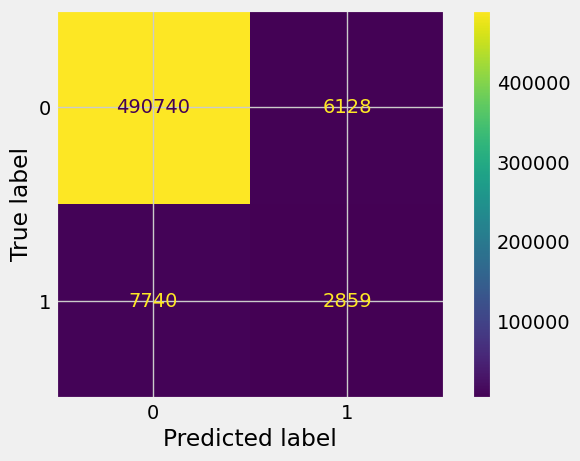

In [ ]:
plt.figure(figsize=(15,7))
ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [ ]:
#Predicting unknown image - data preparation

image_to_predict = RasterDataManipulator(IMAGE_TO_PREDICT_PATH)
image_to_predict.set_band_config(12)
prediction_df = image_to_predict.to_dataframe()
prediction_df.drop(['date'],axis=1,inplace=True)

#Predictions from model
predictions = rf_model.predict(prediction_df)

#Convertion to Mask arr
mask_arr = image_to_predict.preds_to_mask(predictions)
mask_arr.shape

(730, 923)

In [ ]:
#Saving back to raster GeoTIFF

meta_data = image_to_predict.get_meta_data()
file_name = image_to_predict.file_list[0]
mask = rio.open('mask_pred_test.tiff', 'w', driver='GTiff',
                            height = meta_data['height'], width = meta_data['width'],
                            count=1, dtype=meta_data['dtype'],
                            crs=meta_data['crs'],
                            transform=meta_data['transform'])

mask.write(mask_arr, 1)
mask.close()